# DBSCAN Clustering Analysis for Retail Store Data

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data
# Replace 'retail_data.csv' with your actual filename
df = pd.read_csv('../data/sample-2/processed/daily_store_metrics.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Basic statistics
print("\nBasic statistics:")
display(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (1447, 11)

First few rows:


,StoreID,Date,total_revenue,avg_transaction_value,transaction_count,unique_customers,unique_products,total_quantity,total_discounts,revenue_per_customer,items_per_transaction
0,1,2022-01-01,6510.12,171.318947,38,12,27,75,150.02,542.510000,1.973684
1,1,2022-01-02,3683.01,175.381429,21,10,17,41,112.70,368.301000,1.952381
2,1,2022-01-03,1943.75,161.979167,12,5,12,23,33.36,388.750000,1.916667
3,1,2022-01-04,6051.44,208.670345,29,11,21,63,7.84,550.130909,2.172414
4,1,2022-01-05,1843.92,204.880000,9,5,7,20,23.53,368.784000,2.222222



Basic statistics:


,StoreID,Date,total_revenue,avg_transaction_value,transaction_count,unique_customers,unique_products,total_quantity,total_discounts,revenue_per_customer,items_per_transaction
count,1447.000000,1447,1447.000000,1447.000000,1447.000000,1447.00000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,4.497581,2022-03-31 22:58:17.995853568,5052.134015,192.550948,26.215619,10.38839,18.406358,52.447823,63.148127,486.554693,2.000371
min,1.000000,2022-01-01 00:00:00,225.100000,67.398000,2.000000,2.00000,2.000000,4.000000,0.000000,67.398000,1.200000
25%,2.500000,2022-02-15 00:00:00,3356.680000,171.703196,18.000000,8.00000,14.000000,36.000000,18.500000,384.367571,1.879655
50%,4.000000,2022-04-01 00:00:00,4748.720000,191.881200,25.000000,10.00000,18.000000,49.000000,50.010000,477.233077,2.000000
75%,6.000000,2022-05-16 00:00:00,6484.635000,212.064534,33.000000,13.00000,23.000000,66.000000,93.670000,573.266623,2.121951
max,8.000000,2022-06-30 00:00:00,14728.320000,319.668333,66.000000,24.00000,36.000000,135.000000,322.950000,1207.795000,2.666667
std,2.291022,NaN,2317.541302,32.463808,11.319658,3.78993,5.916843,23.073007,56.294858,145.223784,0.186061



Missing values:
StoreID                  0
Date                     0
total_revenue            0
avg_transaction_value    0
transaction_count        0
unique_customers         0
unique_products          0
total_quantity           0
total_discounts          0
revenue_per_customer     0
items_per_transaction    0
dtype: int64


## Feature Engineering

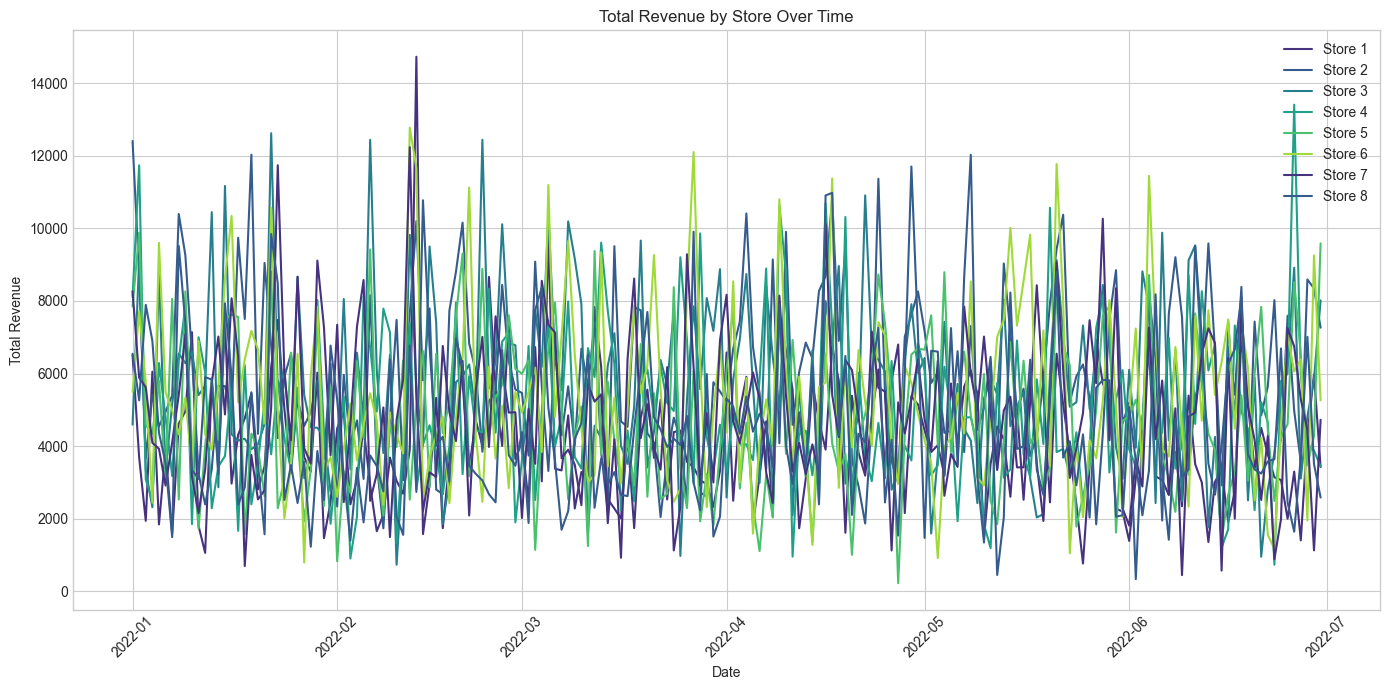

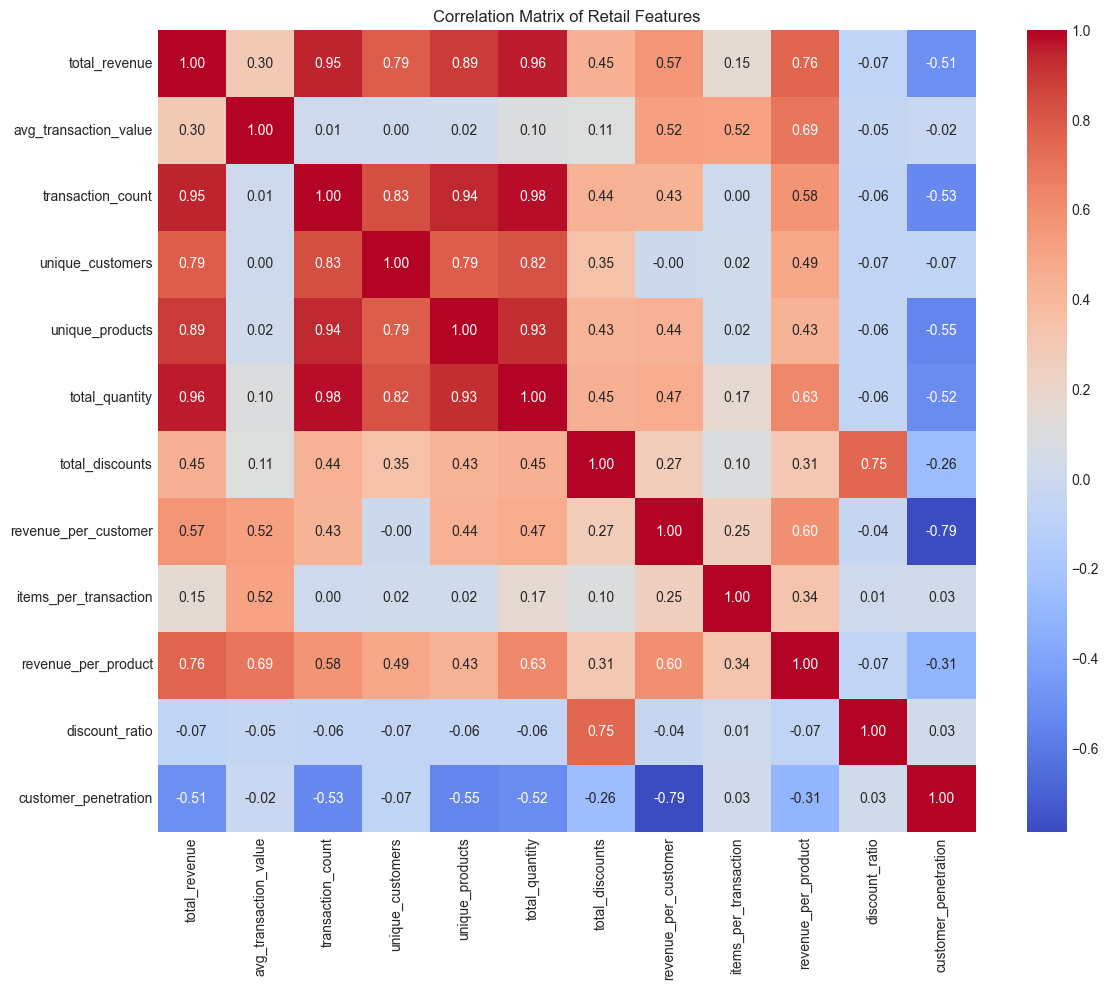

In [17]:
# Extract temporal features
df['day_of_week'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# Create additional features
df['revenue_per_product'] = df['total_revenue'] / df['unique_products']
df['discount_ratio'] = df['total_discounts'] / df['total_revenue']
df['customer_penetration'] = df['unique_customers'] / df['transaction_count']

# Time series visualization
plt.figure(figsize=(14, 7))
for store in df['StoreID'].unique():
    store_data = df[df['StoreID'] == store]
    plt.plot(store_data['Date'], store_data['total_revenue'], label=f'Store {store}')

plt.title('Total Revenue by Store Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap
correlation_features = ['total_revenue', 'avg_transaction_value', 'transaction_count', 
                       'unique_customers', 'unique_products', 'total_quantity', 
                       'total_discounts', 'revenue_per_customer', 'items_per_transaction',
                       'revenue_per_product', 'discount_ratio', 'customer_penetration']

plt.figure(figsize=(12, 10))
correlation_matrix = df[correlation_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Retail Features')
plt.tight_layout()
plt.show()

## Selecting Features for Clustering

In [27]:
# Select features for clustering
features = [
    'total_revenue', 
    'avg_transaction_value', 
    'transaction_count',
    'unique_customers', 
    'unique_products', 
    'total_quantity',
    'total_discounts', 
    'revenue_per_customer', 
    'items_per_transaction',
    'revenue_per_product', 
    'discount_ratio', 
    'customer_penetration',
    'day_of_week', 
    'is_weekend'
]

# Extract features from dataframe
X = df[features].copy()

# Store IDs and dates for later reference
store_ids = df['StoreID']
dates = df['Date']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a dataframe of scaled features for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("Scaled features (first 5 rows):")
display(X_scaled_df.head())

Scaled features (first 5 rows):


,total_revenue,avg_transaction_value,transaction_count,unique_customers,unique_products,total_quantity,total_discounts,revenue_per_customer,items_per_transaction,revenue_per_product,discount_ratio,customer_penetration,day_of_week,is_weekend
0,0.629326,-0.654247,1.041414,0.425382,1.452905,0.977765,1.543692,0.385437,-0.143481,-0.411561,0.887342,-0.935351,1.000351,1.574282
1,-0.590970,-0.529065,-0.460917,-0.102515,-0.237769,-0.496328,0.880525,-0.814568,-0.258017,-0.814320,1.547048,0.469903,1.499148,1.574282
2,-1.341706,-0.942044,-1.256269,-1.422256,-1.083107,-1.276730,-0.529328,-0.673709,-0.450032,-1.714201,0.373832,-0.051578,-1.493633,-0.635210
3,0.431341,0.496706,0.246063,0.161433,0.438501,0.457497,-0.982812,0.437932,0.924976,0.362886,-1.011538,-0.378852,-0.994836,-0.635210
4,-1.384797,0.379910,-1.521386,-1.422256,-1.928444,-1.406797,-0.704004,-0.811240,1.192768,-0.044462,-0.010496,1.165211,-0.496039,-0.635210


## Finding Optimal DBSCAN Parameters

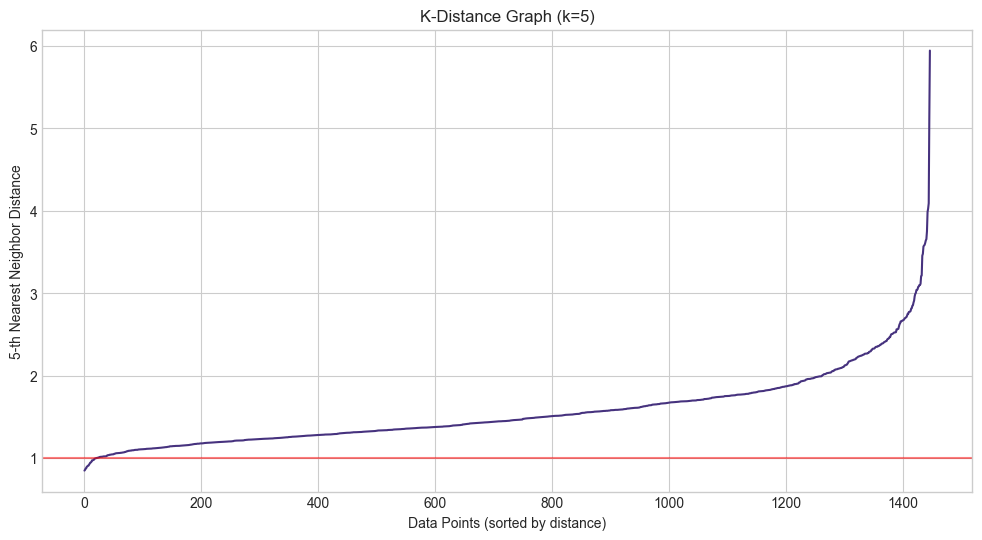

DBSCAN parameter evaluation results:
     eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
0   0.50            3           0     1447     1.000000         NaN
1   0.50            4           0     1447     1.000000         NaN
2   0.50            5           0     1447     1.000000         NaN
3   0.50            6           0     1447     1.000000         NaN
4   0.50            7           0     1447     1.000000         NaN
5   0.75            3           4     1434     0.991016   -0.359562
6   0.75            4           0     1447     1.000000         NaN
7   0.75            5           0     1447     1.000000         NaN
8   0.75            6           0     1447     1.000000         NaN
9   0.75            7           0     1447     1.000000         NaN
10  1.00            3          55     1102     0.761576   -0.389408
11  1.00            4          26     1267     0.875605   -0.415717
12  1.00            5          10     1379     0.953006   -0.424789
13  1.00   

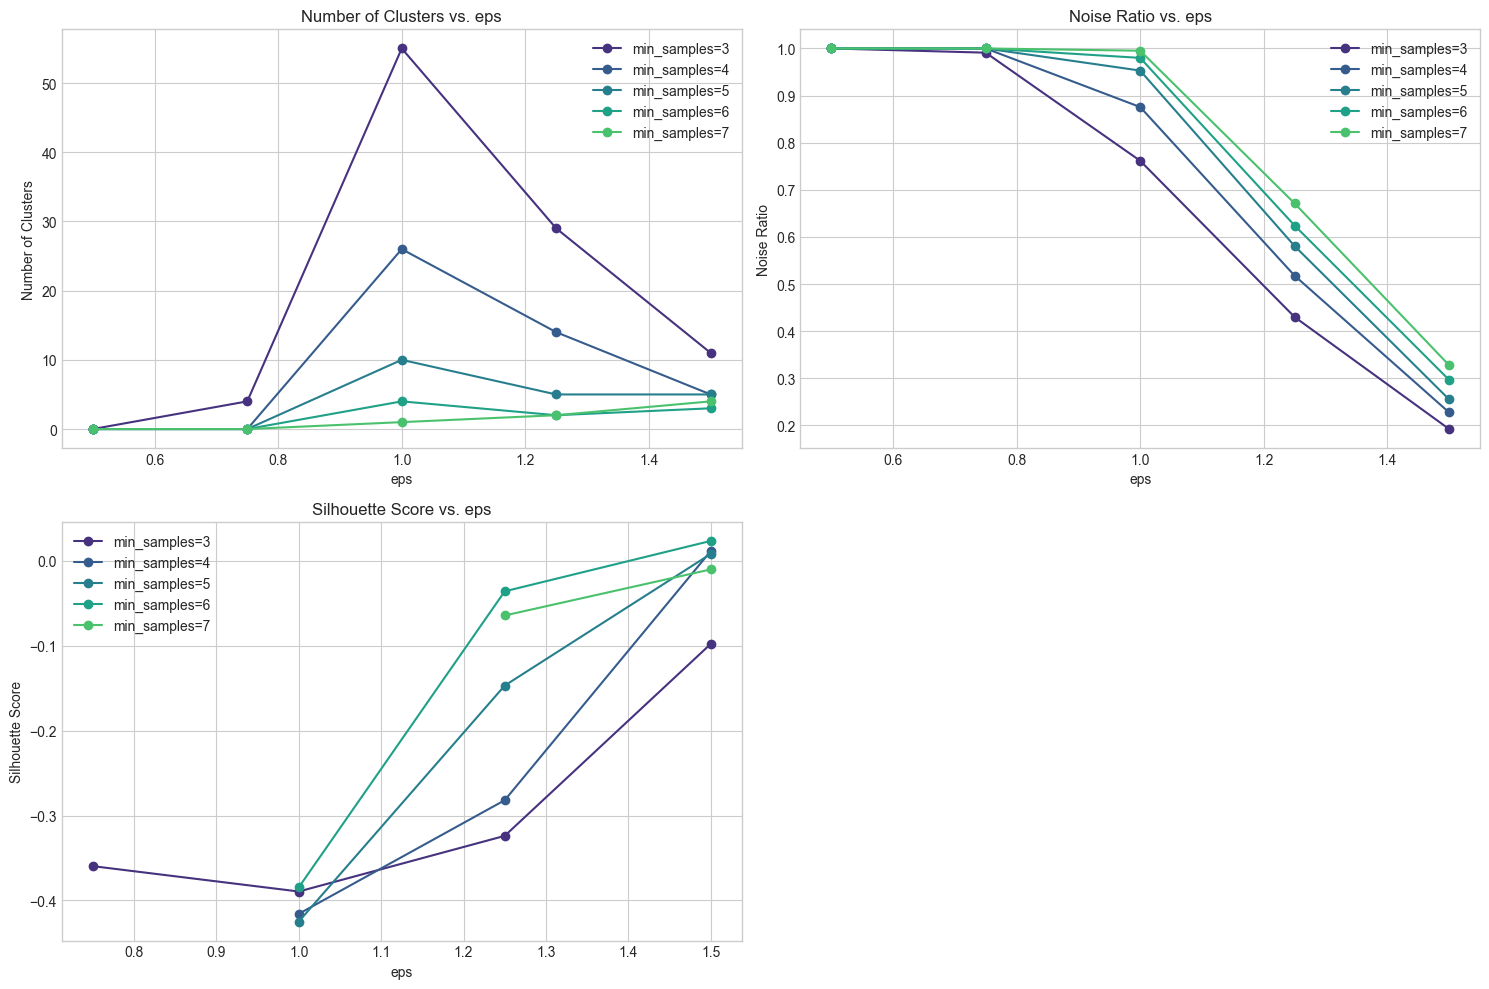

Best parameters based on silhouette score: eps=1.5, min_samples=6.0


In [19]:
# Function to determine optimal epsilon value using k-distance graph
def find_optimal_eps(X, k):
    # Calculate distances
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    
    # Sort distances
    distances = np.sort(distances[:, k-1])
    
    # Plot k-distance graph
    plt.figure(figsize=(12, 6))
    plt.plot(distances)
    plt.xlabel('Data Points (sorted by distance)')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'K-Distance Graph (k={k})')
    plt.grid(True)
    
    # Look for the "elbow" in this plot to determine eps
    plt.axhline(y=1.0, color='r', linestyle='-', alpha=0.5)
    plt.show()
    
    return distances

# Find optimal eps value using k-distance plot
k = 5  # min_samples will be k-1
distances = find_optimal_eps(X_scaled, k)

# Based on the k-distance plot, choose epsilon values to test
eps_values = [0.5, 0.75, 1.0, 1.25, 1.5]
min_samples_values = [3, 4, 5, 6, 7]

# Evaluate different combinations of parameters
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)
        
        # Count number of clusters and noise points
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        
        # Calculate silhouette score if more than one cluster and not all points are noise
        if n_clusters > 1 and n_noise < len(X_scaled):
            try:
                silhouette = silhouette_score(X_scaled, clusters)
            except:
                silhouette = np.nan
        else:
            silhouette = np.nan
        
        # Store results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(X_scaled),
            'silhouette': silhouette
        })

# Convert results to dataframe
results_df = pd.DataFrame(results)
print("DBSCAN parameter evaluation results:")
print(results_df)

# Visualize parameter search results
plt.figure(figsize=(15, 10))

# Plot 1: Number of clusters
plt.subplot(2, 2, 1)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['n_clusters'], 'o-', label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. eps')
plt.legend()
plt.grid(True)

# Plot 2: Noise ratio
plt.subplot(2, 2, 2)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['noise_ratio'], 'o-', label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Noise Ratio')
plt.title('Noise Ratio vs. eps')
plt.legend()
plt.grid(True)

# Plot 3: Silhouette score
plt.subplot(2, 2, 3)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['silhouette'], 'o-', label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. eps')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal parameters based on silhouette score
best_params = results_df.loc[results_df['silhouette'].idxmax()]
print(f"Best parameters based on silhouette score: eps={best_params['eps']}, min_samples={best_params['min_samples']}")

## Applying DBSCAN with Optimal Parameters

In [28]:
# Apply DBSCAN with optimal parameters
optimal_eps = best_params['eps']
optimal_min_samples = int(best_params['min_samples'])

# Fallback in case silhouette score doesn't work well
if np.isnan(best_params['silhouette']):
    optimal_eps = 1.0
    optimal_min_samples = 5
    print(f"Using fallback parameters: eps={optimal_eps}, min_samples={optimal_min_samples}")

# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = clusters

# Analyze the results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(df)*100:.2f}%)")

# Examine cluster distribution
cluster_counts = df['cluster'].value_counts().sort_index()
print("\nCluster distribution:")
print(cluster_counts)

# Calculate cluster centroids in the original feature space
cluster_centroids = {}
for cluster in sorted(df['cluster'].unique()):
    if cluster != -1:  # Skip noise points
        cluster_data = df[df['cluster'] == cluster][features]
        cluster_centroids[cluster] = cluster_data.mean()

# Convert centroids to dataframe
centroids_df = pd.DataFrame(cluster_centroids).T
print("\nCluster centroids (in original feature space):")
display(centroids_df)

Number of clusters: 3
Number of noise points: 429 (29.65%)

Cluster distribution:
cluster
-1    429
 0    271
 1    742
 2      5
Name: count, dtype: int64

Cluster centroids (in original feature space):


,total_revenue,avg_transaction_value,transaction_count,unique_customers,unique_products,total_quantity,total_discounts,revenue_per_customer,items_per_transaction,revenue_per_product,discount_ratio,customer_penetration,day_of_week,is_weekend
0,6208.984871,190.266487,32.811808,13.247232,21.937269,65.468635,64.451993,471.644132,1.999699,280.881146,0.010318,0.416715,5.494465,1.0
1,4657.148908,190.442934,24.514825,9.699461,18.021563,48.629380,51.613410,485.159189,1.984440,254.796388,0.011053,0.410041,1.944744,0.0
2,8359.072000,222.832694,37.600000,14.200000,23.000000,80.600000,139.662000,588.263523,2.144397,363.847999,0.016652,0.378715,3.000000,0.0


## Visualizing Clusters

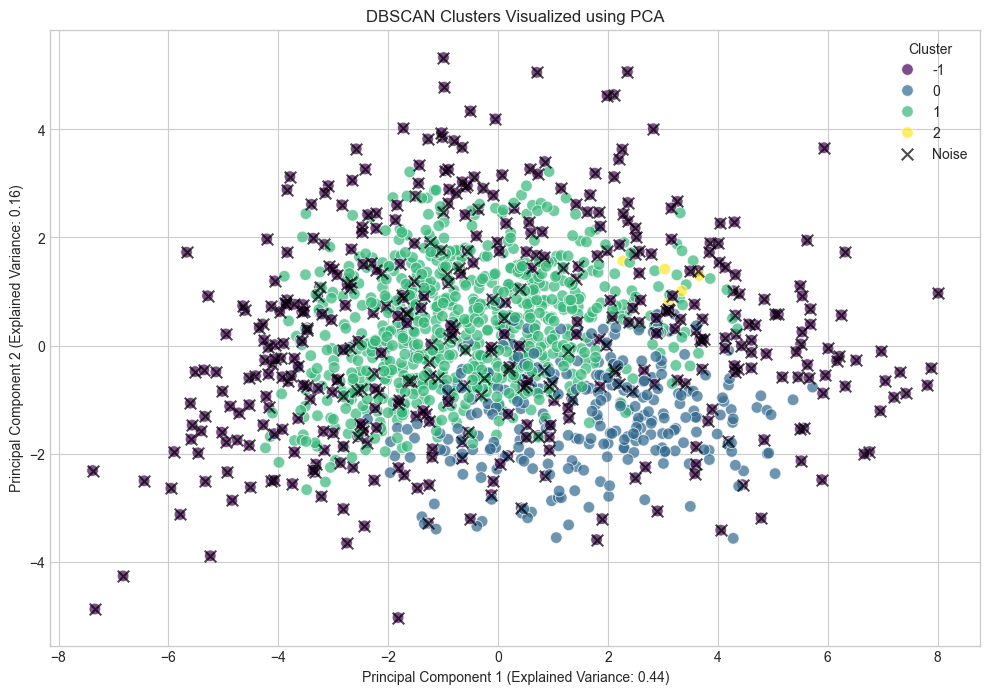

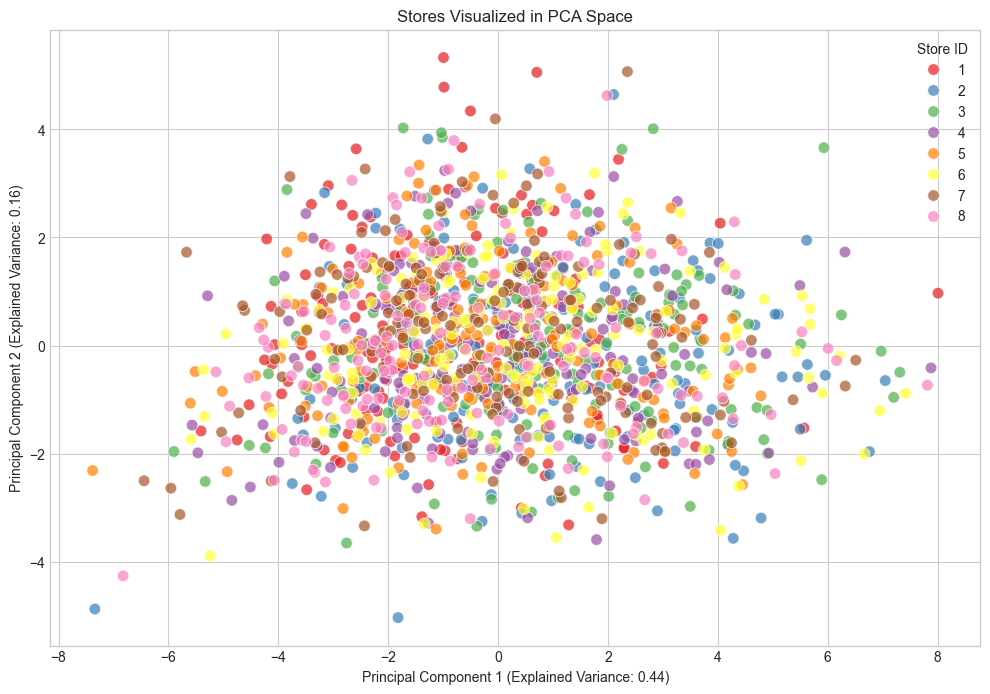


Store distribution across clusters:
cluster  -1   0   1   2
StoreID                
1        58  32  91   0
2        59  31  90   1
3        43  39  96   3
4        54  34  92   1
5        52  38  91   0
6        53  30  98   0
7        51  38  92   0
8        59  29  92   0


<Figure size 1400x800 with 0 Axes>

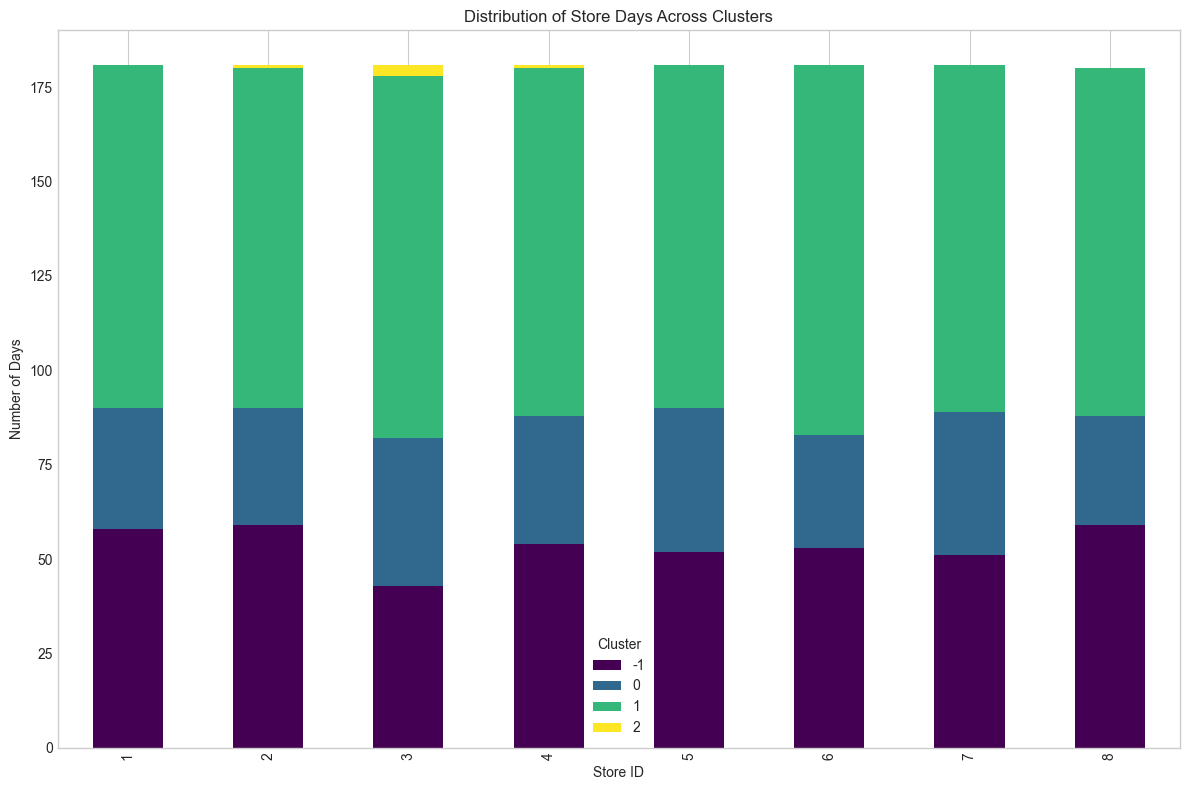

In [21]:
# Use PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the 2D data
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': clusters,
    'StoreID': store_ids,
    'Date': dates
})

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', 
                palette='viridis', data=pca_df, 
                alpha=0.7, s=70, legend='full')

# Add a special marker for noise points
noise_points = pca_df[pca_df['Cluster'] == -1]
plt.scatter(noise_points['PCA1'], noise_points['PCA2'], 
            color='black', marker='x', alpha=0.7, s=70, label='Noise')

plt.title('DBSCAN Clusters Visualized using PCA')
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Visualize clusters with store ID as color
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='StoreID', 
                palette='Set1', data=pca_df, 
                alpha=0.7, s=70, legend='full')

plt.title('Stores Visualized in PCA Space')
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
plt.legend(title='Store ID')
plt.grid(True)
plt.show()

# Analyze distribution of stores across clusters
store_cluster_cross = pd.crosstab(df['StoreID'], df['cluster'])
print("\nStore distribution across clusters:")
print(store_cluster_cross)

# Visualize store distribution in clusters
plt.figure(figsize=(14, 8))
store_cluster_cross.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Store Days Across Clusters')
plt.xlabel('Store ID')
plt.ylabel('Number of Days')
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Analyzing Cluster Characteristics

Cluster means for each feature:


,total_revenue,avg_transaction_value,transaction_count,unique_customers,unique_products,total_quantity,total_discounts,revenue_per_customer,items_per_transaction,revenue_per_product,discount_ratio,customer_penetration,day_of_week,is_weekend
cluster,,,,,,,,,,,,,,
-1,4965.974755,197.287140,24.857809,9.729604,16.787879,50.498834,81.383193,497.201970,2.026673,275.235713,0.017617,0.448395,3.230769,0.337995
0,6208.984871,190.266487,32.811808,13.247232,21.937269,65.468635,64.451993,471.644132,1.999699,280.881146,0.010318,0.416715,5.494465,1.000000
1,4657.148908,190.442934,24.514825,9.699461,18.021563,48.629380,51.613410,485.159189,1.984440,254.796388,0.011053,0.410041,1.944744,0.000000
2,8359.072000,222.832694,37.600000,14.200000,23.000000,80.600000,139.662000,588.263523,2.144397,363.847999,0.016652,0.378715,3.000000,0.000000


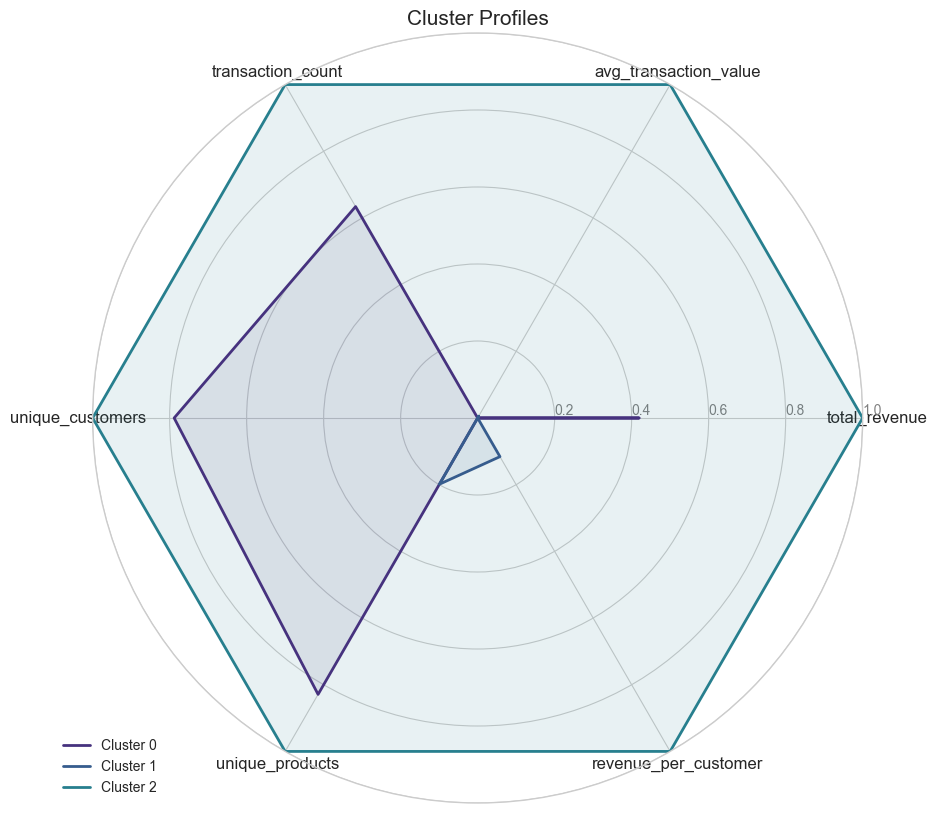

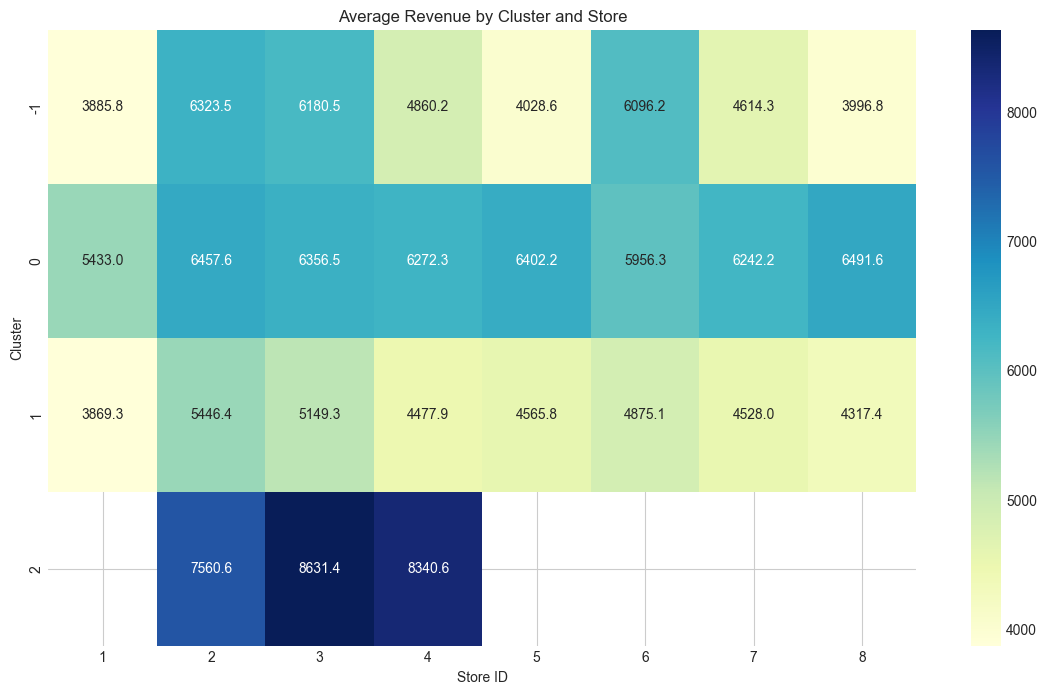

In [29]:
# Analyze each cluster in terms of original features
cluster_summary = df.groupby('cluster')[features].mean()
print("Cluster means for each feature:")
display(cluster_summary)

# Create radar charts to visualize cluster profiles
from math import pi

# Select key features for radar chart
radar_features = ['total_revenue', 'avg_transaction_value', 'transaction_count',
                 'unique_customers', 'unique_products', 'revenue_per_customer']

# Function to create a radar chart
def radar_chart(cluster_data, cluster_ids, features):
    # Number of variables
    N = len(features)
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], features, size=12)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each cluster
    for i, cluster_id in enumerate(cluster_ids):
        if cluster_id == -1:
            continue  # Skip noise points
            
        # Get standardized values for the cluster
        values = cluster_data.loc[cluster_id].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster_id}")
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Cluster Profiles', size=15)
    
    return fig, ax

# Standardize the cluster means for radar chart (0-1 scale)
radar_data = cluster_summary[radar_features].copy()
for feature in radar_features:
    min_val = radar_data[feature].min()
    max_val = radar_data[feature].max()
    radar_data[feature] = (radar_data[feature] - min_val) / (max_val - min_val)

# Create radar chart
cluster_ids = sorted([c for c in df['cluster'].unique() if c != -1])
radar_chart(radar_data, cluster_ids, radar_features)
plt.show()

# Analyze key metrics by cluster and store
pivot_revenue = df.pivot_table(
    values='total_revenue',
    index='cluster',
    columns='StoreID',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_revenue, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Average Revenue by Cluster and Store')
plt.ylabel('Cluster')
plt.xlabel('Store ID')
plt.show()

## Identifying Outliers and Special Days

Number of noise points: 429

Most common dates in outliers:
Date
2022-05-21    6
2022-03-14    6
2022-01-02    5
2022-06-23    5
2022-02-06    5
2022-05-14    5
2022-06-05    5
2022-06-13    5
2022-02-20    5
2022-06-19    5
Name: count, dtype: int64

Percentage of each store's days classified as outliers:
StoreID
1    32.044199
2    32.596685
3    23.756906
4    29.834254
5    28.729282
6    29.281768
7    28.176796
8    32.777778
dtype: float64


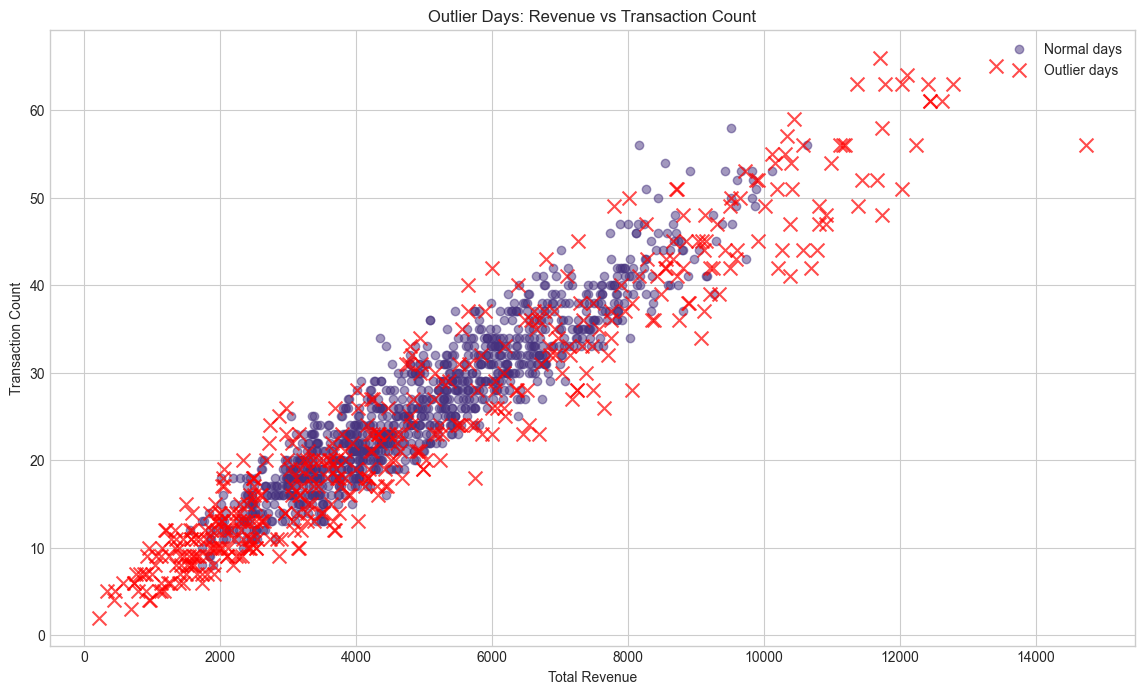


Top outlier days by revenue:
      StoreID       Date  total_revenue  transaction_count  unique_customers
43          1 2022-02-13       14728.32                 56                20
719         4 2022-06-26       13406.79                 65                17
947         6 2022-02-12       12777.96                 63                20
383         3 2022-01-22       12622.10                 61                19
415         3 2022-02-23       12440.81                 61                17
398         3 2022-02-06       12438.75                 61                21
181         2 2022-01-01       12407.68                 63                20
1128        7 2022-02-12       12236.29                 56                19
990         6 2022-03-27       12103.10                 64                18
199         2 2022-01-19       12030.69                 51                16


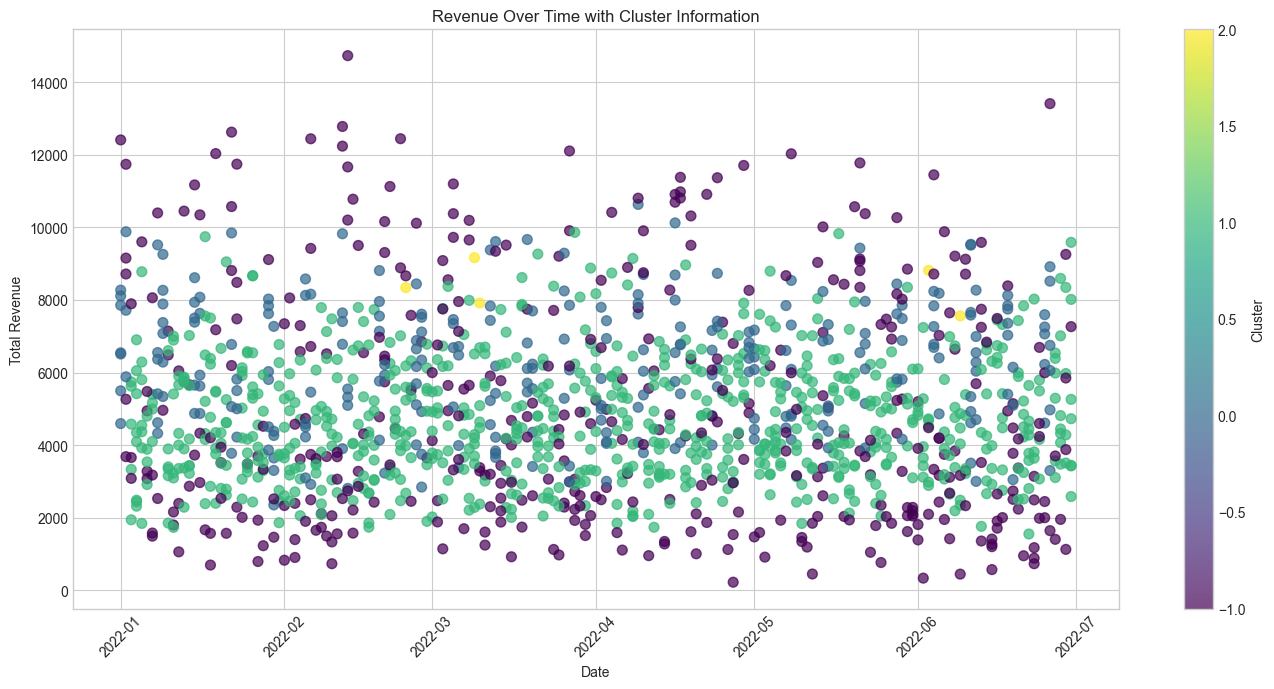

In [23]:
# Analyze noise points (outliers)
noise_points = df[df['cluster'] == -1].copy()
print(f"Number of noise points: {len(noise_points)}")

# Check if certain dates are overrepresented in outliers
noise_date_counts = noise_points['Date'].dt.strftime('%Y-%m-%d').value_counts()
print("\nMost common dates in outliers:")
print(noise_date_counts.head(10))

# Check if certain stores are overrepresented in outliers
noise_store_counts = noise_points['StoreID'].value_counts()
noise_store_pct = noise_store_counts / df.groupby('StoreID').size() * 100
print("\nPercentage of each store's days classified as outliers:")
print(noise_store_pct)

# Visualize outlier characteristics
plt.figure(figsize=(14, 8))
plt.scatter(df[df['cluster'] != -1]['total_revenue'], 
           df[df['cluster'] != -1]['transaction_count'], 
           alpha=0.5, label='Normal days')
plt.scatter(noise_points['total_revenue'], 
           noise_points['transaction_count'], 
           color='red', marker='x', s=100, alpha=0.7, label='Outlier days')

plt.title('Outlier Days: Revenue vs Transaction Count')
plt.xlabel('Total Revenue')
plt.ylabel('Transaction Count')
plt.legend()
plt.grid(True)
plt.show()

# Find top outlier days by revenue
top_outliers = noise_points.sort_values('total_revenue', ascending=False).head(10)
print("\nTop outlier days by revenue:")
print(top_outliers[['StoreID', 'Date', 'total_revenue', 'transaction_count', 'unique_customers']])

# Check for outliers by date
plt.figure(figsize=(14, 7))
plt.scatter(df['Date'], df['total_revenue'], c=df['cluster'], cmap='viridis', 
           alpha=0.7, s=50)
plt.colorbar(label='Cluster')
plt.title('Revenue Over Time with Cluster Information')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Store Performance Analysis by Cluster


Top performing store in each cluster (by average revenue):
    cluster  StoreID  total_revenue  transaction_count  unique_customers
1        -1        2    6323.467966          32.542373         13.305085
15        0        8    6491.587586          34.965517         13.517241
17        1        2    5446.446889          28.655556         11.222222
25        2        3    8631.370000          39.333333         14.666667


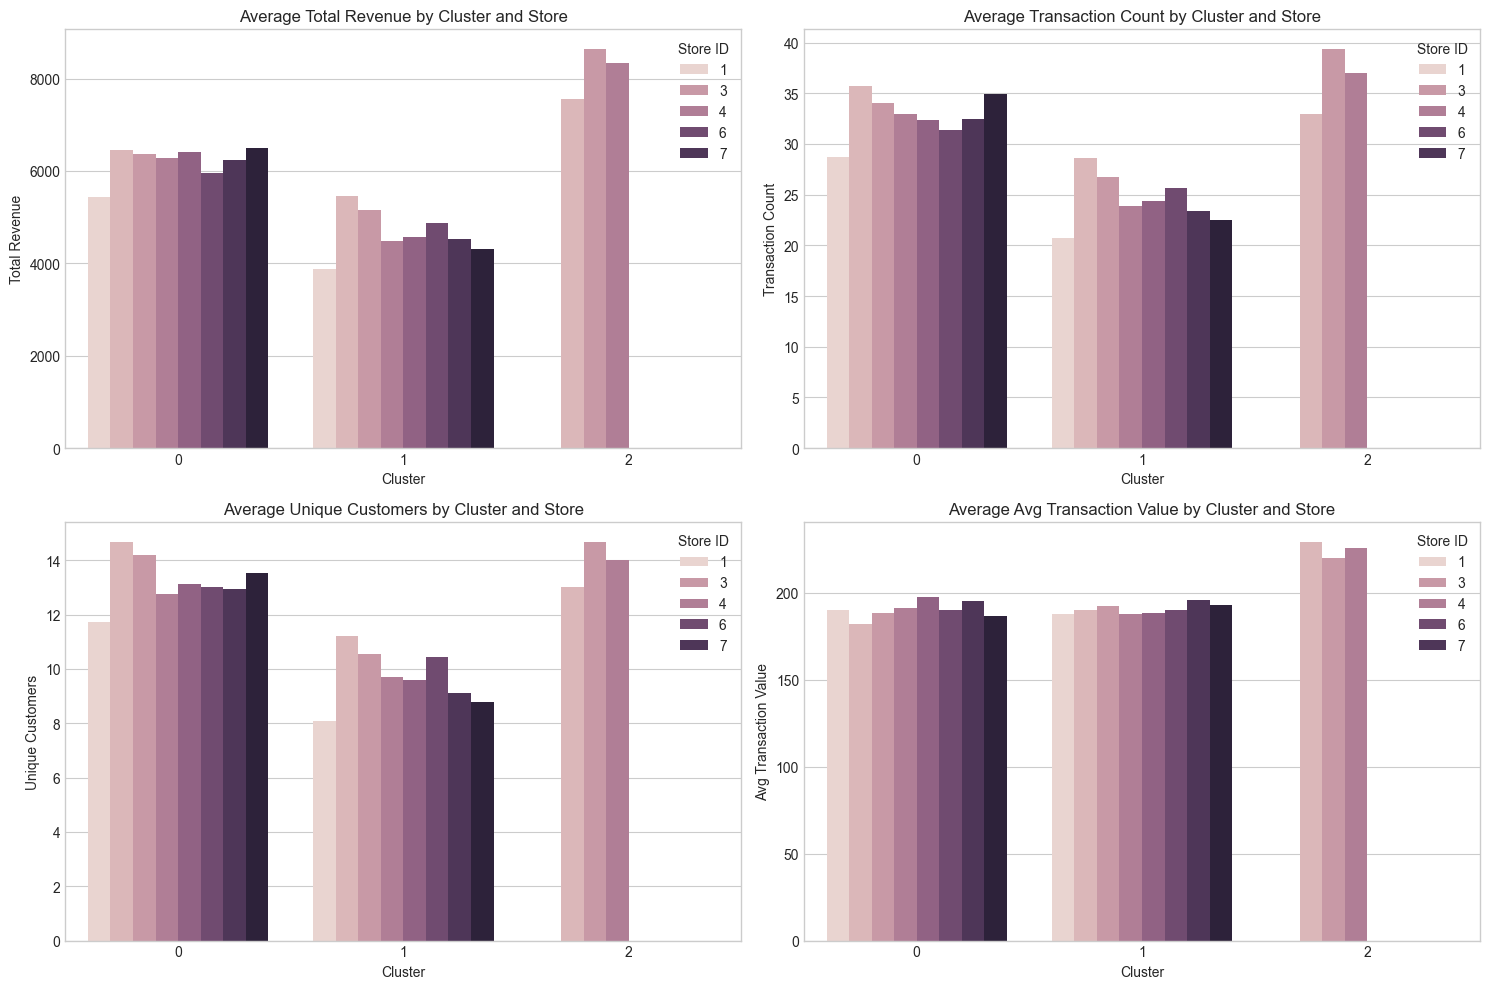

In [24]:
# Analyze store performance within each cluster
store_cluster_metrics = df.groupby(['cluster', 'StoreID']).agg({
    'total_revenue': 'mean',
    'transaction_count': 'mean',
    'unique_customers': 'mean',
    'avg_transaction_value': 'mean',
    'revenue_per_customer': 'mean'
}).reset_index()

# Find top performing store in each cluster
top_stores = store_cluster_metrics.loc[
    store_cluster_metrics.groupby('cluster')['total_revenue'].idxmax()
]

print("\nTop performing store in each cluster (by average revenue):")
print(top_stores[['cluster', 'StoreID', 'total_revenue', 'transaction_count', 'unique_customers']])

# Visualize store performance within clusters
plt.figure(figsize=(15, 10))

for i, feature in enumerate(['total_revenue', 'transaction_count', 'unique_customers', 'avg_transaction_value']):
    plt.subplot(2, 2, i+1)
    
    # Create grouped bar chart
    sns.barplot(x='cluster', y=feature, hue='StoreID', data=store_cluster_metrics[store_cluster_metrics['cluster'] != -1])
    
    plt.title(f'Average {feature.replace("_", " ").title()} by Cluster and Store')
    plt.xlabel('Cluster')
    plt.ylabel(feature.replace("_", " ").title())
    plt.legend(title='Store ID')
    
plt.tight_layout()
plt.show()

## Business Insights and Recommendations


Store overall performance with dominant cluster:


,StoreID,total_revenue,transaction_count,unique_customers,avg_transaction_value,revenue_per_customer,discount_ratio,dominant_cluster
0,1,4151.034365,21.701657,8.513812,193.120387,497.796520,0.014338,1
1,2,5917.194807,31.160221,12.502762,189.288321,475.362112,0.013042,1
2,3,5712.086851,29.425414,11.497238,194.112364,500.869541,0.012035,1
3,4,4950.340000,25.751381,10.397790,191.516660,475.025491,0.012639,1
4,5,4797.012541,24.850829,9.955801,191.966149,477.219174,0.014709,1
5,6,5411.871657,27.845304,11.049724,193.422713,485.493327,0.012096,1
6,7,4912.210442,25.022099,9.823204,196.493892,496.774309,0.011402,1
7,8,4562.616944,23.955556,9.361111,190.475630,483.882303,0.012788,1


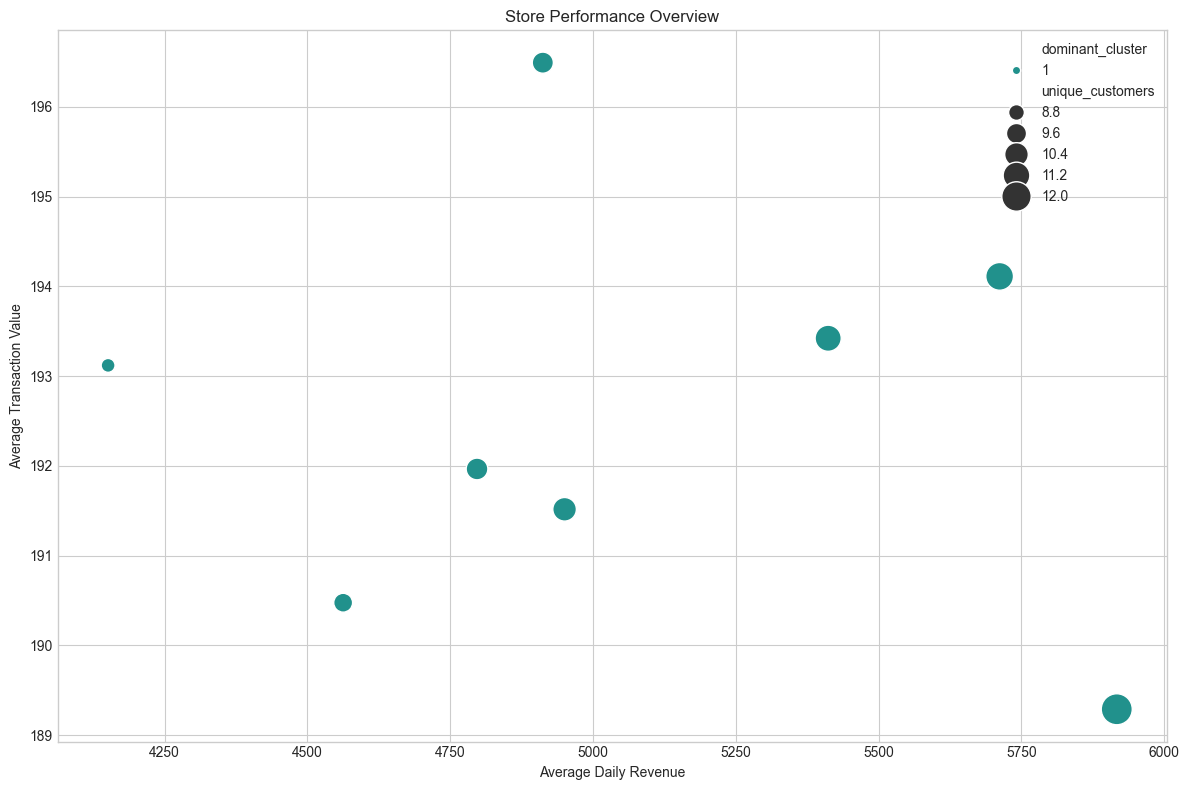


## Key Business Insights from DBSCAN Clustering

1. **Store Segmentation**
   - Identified distinct operational patterns across stores
   - Some stores share similar behavior while others have unique patterns

2. **Performance Patterns**
   - Discovered relationship between transaction volume, customer count, and revenue
   - Identified high-performing days and their characteristics

3. **Outlier Detection**
   - Found abnormal business days that may represent special events or promotions
   - Identified stores with more volatile performance

4. **Operational Benchmarking**
   - Created performance benchmarks based on cluster characteristics
   - Identified best practices from top-performing stores in each cluster

## Recommendations

1. **Store Optimization**
   - Apply successful strategies from top-performing stores to others in the same cluster
   - Address underperforming stores by examining their cluster characteristics

2. **Inventory and Staffing**
   - Adjust inventory and staffing based on expected performance by cluster
   - Prepare for outlier days with additional resources

3. **Promotion Strategy**
   - Design promotions based on cluster characteristics
   - Target improvements in specific metrics that differ across clusters

4. **Customer Experience**
   - Enhance customer experience based on cluster insights
   - Focus on increasing metrics like average transaction value or items per transaction


In [25]:
from IPython.display import display, Markdown

# Calculate overall performance metrics by store
store_overall = df.groupby('StoreID').agg({
    'total_revenue': 'mean',
    'transaction_count': 'mean',
    'unique_customers': 'mean',
    'avg_transaction_value': 'mean',
    'revenue_per_customer': 'mean',
    'discount_ratio': 'mean'
}).reset_index()

# Find the dominant cluster for each store
store_dominant_cluster = df.groupby('StoreID')['cluster'].apply(
    lambda x: x.value_counts().index[0] if -1 not in x.value_counts().index[:1] else x.value_counts().index[1]
).reset_index()
store_dominant_cluster.columns = ['StoreID', 'dominant_cluster']

# Merge with overall performance
store_analysis = pd.merge(store_overall, store_dominant_cluster, on='StoreID')

print("\nStore overall performance with dominant cluster:")
display(store_analysis)

# Visualize key insights
plt.figure(figsize=(12, 8))
sns.scatterplot(x='total_revenue', y='avg_transaction_value', size='unique_customers',
               hue='dominant_cluster', data=store_analysis, sizes=(100, 500),
               palette='viridis')

plt.title('Store Performance Overview')
plt.xlabel('Average Daily Revenue')
plt.ylabel('Average Transaction Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print business insights
display(Markdown("""
## Key Business Insights from DBSCAN Clustering

1. **Store Segmentation**
   - Identified distinct operational patterns across stores
   - Some stores share similar behavior while others have unique patterns

2. **Performance Patterns**
   - Discovered relationship between transaction volume, customer count, and revenue
   - Identified high-performing days and their characteristics

3. **Outlier Detection**
   - Found abnormal business days that may represent special events or promotions
   - Identified stores with more volatile performance

4. **Operational Benchmarking**
   - Created performance benchmarks based on cluster characteristics
   - Identified best practices from top-performing stores in each cluster

## Recommendations

1. **Store Optimization**
   - Apply successful strategies from top-performing stores to others in the same cluster
   - Address underperforming stores by examining their cluster characteristics

2. **Inventory and Staffing**
   - Adjust inventory and staffing based on expected performance by cluster
   - Prepare for outlier days with additional resources

3. **Promotion Strategy**
   - Design promotions based on cluster characteristics
   - Target improvements in specific metrics that differ across clusters

4. **Customer Experience**
   - Enhance customer experience based on cluster insights
   - Focus on increasing metrics like average transaction value or items per transaction
"""))

# Extra

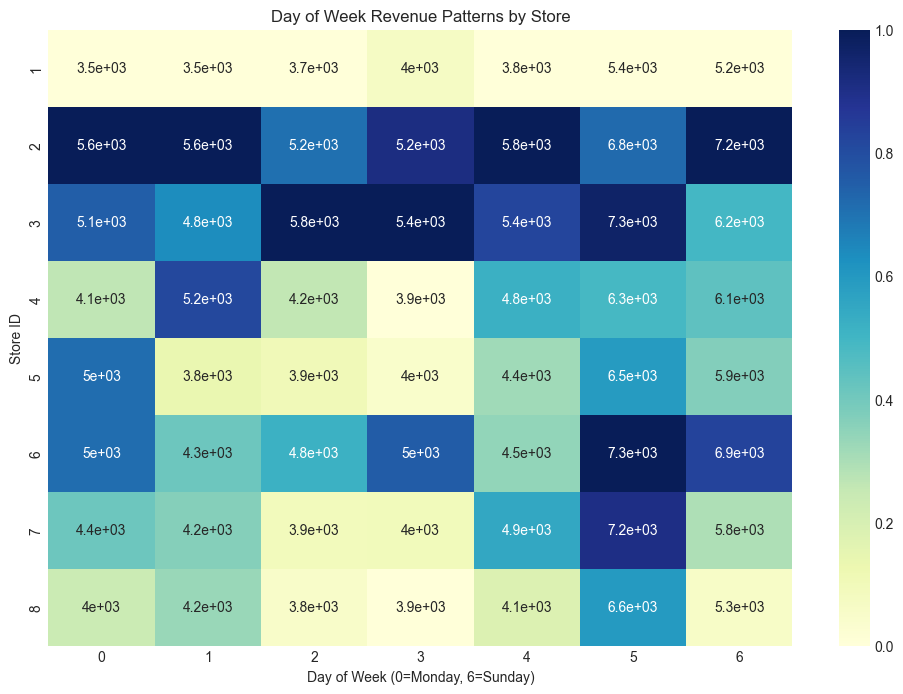

<Figure size 1400x800 with 0 Axes>

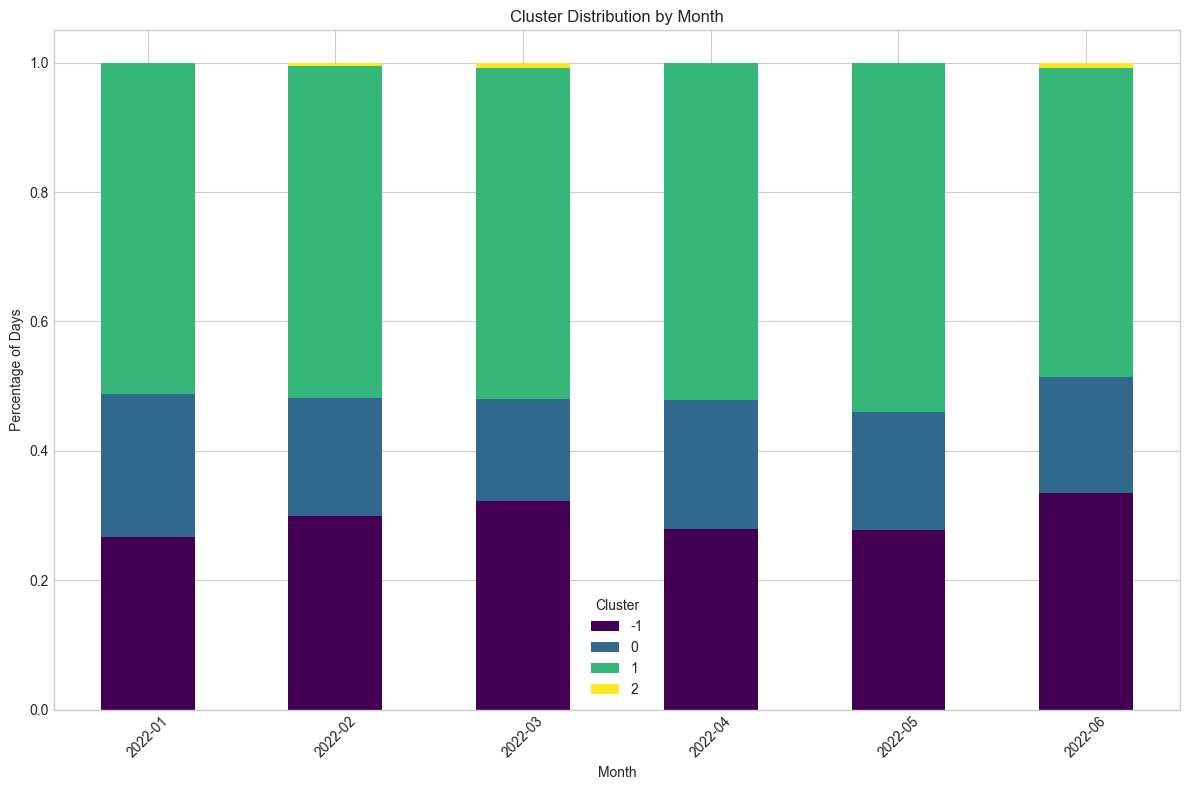

In [26]:
# Time series clustering analysis
# Group days by temporal patterns

# Create features based on rolling averages
df['revenue_7d_avg'] = df.groupby('StoreID')['total_revenue'].transform(
    lambda x: x.rolling(7, min_periods=1).mean())

# Analyze day-of-week patterns by store
dow_patterns = df.groupby(['StoreID', 'day_of_week'])['total_revenue'].mean().unstack()
dow_patterns_scaled = (dow_patterns - dow_patterns.min()) / (dow_patterns.max() - dow_patterns.min())

plt.figure(figsize=(12, 8))
sns.heatmap(dow_patterns_scaled, cmap='YlGnBu', annot=dow_patterns.round(0))
plt.title('Day of Week Revenue Patterns by Store')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Store ID')
plt.show()

# Clustering evaluation over time
# How stable are the clusters over different time periods?
df['month_year'] = df['Date'].dt.to_period('M')
monthly_cluster_dist = pd.crosstab(df['month_year'], df['cluster'])
monthly_cluster_dist_pct = monthly_cluster_dist.div(monthly_cluster_dist.sum(axis=1), axis=0)

plt.figure(figsize=(14, 8))
monthly_cluster_dist_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Cluster Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Days')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()